In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [3]:
X.shape

(178, 13)

In [4]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [6]:
df = X.join(pd.Series(y, name='class'))

Linear Discriminant Analysis can be broken up into the following steps:
Compute the within class and between class scatter matrices
Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
Sort the eigenvalues and select the top k
Create a new matrix containing eigenvectors that map to the k eigenvalues
Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4. For every class, we create a vector with the means of each feature.

In [7]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


Then, we plug the mean vectors (mi) into the equation from before in order to obtain the within class scatter matrix. 

In [8]:
within_class_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
  rows = rows.drop(['class'], axis=1)
  s = np.zeros((13,13))
for index, row in rows.iterrows():
        x, mc = row.values.reshape(13,1), class_feature_means[c].values.reshape(13,1)
        s += (x - mc).dot((x - mc).T)
        within_class_scatter_matrix += s

In [9]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [10]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

The eigenvectors with the highest eigenvalues carry the most information about the distribution of the data. Thus, we sort the eigenvalues from highest to lowest and select the first k eigenvectors. In order to ensure that the eigenvalue maps to the same eigenvector after sorting, we place them in a temporary array.

In [11]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.884546449232964
2.9033610617160606
6.285916968291436e-16
6.285916968291436e-16
5.979482586809227e-16
5.345289989557e-16
5.345289989557e-16
2.5624197998855253e-16
2.5624197998855253e-16
2.4778227778444637e-16
5.049704088349899e-17
1.0023889228649853e-17
0.0


It is difficult to determine how much of the variance is explained by each component. Thus, we express it as a percentage.

In [12]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.772960426932225
Eigenvector 1: 0.22703957306777506
Eigenvector 2: 4.915516446228146e-17
Eigenvector 3: 4.915516446228146e-17
Eigenvector 4: 4.6758882027333914e-17
Eigenvector 5: 4.179956716906465e-17
Eigenvector 6: 4.179956716906465e-17
Eigenvector 7: 2.0037834944392412e-17
Eigenvector 8: 2.0037834944392412e-17
Eigenvector 9: 1.9376295736600758e-17
Eigenvector 10: 3.948811863102963e-18
Eigenvector 11: 7.838568757294643e-19
Eigenvector 12: 0.0


First, we create a matrix W with the first two eigenvectors.

In [13]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real
w_matrix

array([[-4.1562e-02,  2.0879e-01],
       [-1.6684e-02,  3.6500e-03],
       [-4.4776e-03,  4.5911e-01],
       [ 7.5359e-03, -2.4950e-02],
       [ 6.4335e-03,  3.1071e-03],
       [ 9.7213e-02,  1.9083e-01],
       [-7.2041e-01,  2.6494e-02],
       [-6.5156e-01,  3.4334e-01],
       [ 1.6083e-02, -4.0468e-01],
       [ 2.7091e-02,  6.7012e-03],
       [-1.9634e-02, -5.7682e-01],
       [-2.0866e-01, -3.0567e-01],
       [-5.9173e-04,  9.9706e-04]])

Then, we save the dot product of X and W into a new matrix Y.
where X is a n×d matrix with n samples and d dimensions, and Y is a n×k matrix with n samples and k ( k<n) dimensions. 
In other words, Y is composed of the LDA components, or said yet another way, the new feature space.

In [14]:
X_lda = np.array(X.dot(w_matrix))
X_lda

array([[-3.0898,  3.1846],
       [-2.9724,  3.3577],
       [-3.2495,  3.0743],
       [-3.4498,  4.0917],
       [-2.5291,  3.2034],
       [-3.4   ,  4.1123],
       [-3.0367,  3.5544],
       [-2.8555,  3.8611],
       [-3.049 ,  3.5449],
       [-3.1342,  3.2478],
       [-3.455 ,  3.5023],
       [-2.7984,  3.6056],
       [-3.0704,  3.6012],
       [-3.7015,  3.5086],
       [-3.6974,  3.7308],
       [-2.9534,  3.8804],
       [-3.0524,  3.9394],
       [-3.166 ,  3.7823],
       [-3.8682,  4.2839],
       [-2.8555,  3.2937],
       [-2.9092,  2.9224],
       [-2.5376,  2.7191],
       [-3.1722,  3.03  ],
       [-2.7119,  3.0313],
       [-2.8484,  2.8515],
       [-2.6393,  3.1509],
       [-3.1843,  3.7527],
       [-2.6081,  3.5686],
       [-3.0052,  3.2753],
       [-2.6955,  3.0687],
       [-3.1836,  3.4638],
       [-3.2407,  3.7421],
       [-2.8603,  3.1465],
       [-2.8395,  3.9321],
       [-2.6655,  3.5116],
       [-2.9779,  2.9484],
       [-2.6427,  3.6009],
 

Matplotlib cannot handle categorical variables directly. Thus, we encode every class as a number so that we can incorporate the class labels into our plot.

In [15]:
le = LabelEncoder()
y = le.fit_transform(df['class'])

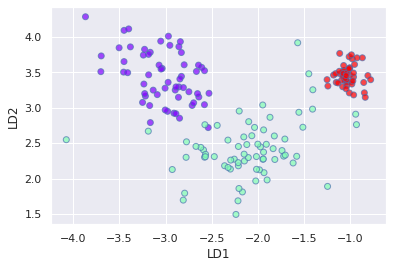

In [16]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

Rather than implementing the Linear Discriminant Analysis algorithm from scratch every time, we can use the predefined LinearDiscriminantAnalysis class made available to us by the scikit-learn library.

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [18]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

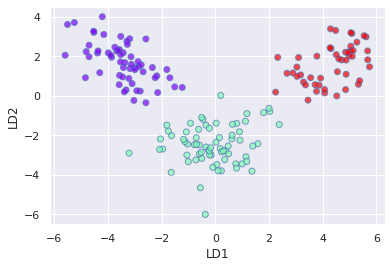

In [19]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

Next, let’s take a look at how LDA compares to Principal Component Analysis or PCA. We start off by creating and fitting an instance of the PCA class.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

In [21]:
pca.explained_variance_ratio_

array([0.9981, 0.0017])

As we can see, PCA selected the components which would result in the highest spread (retain the most information) and not necessarily the ones which maximize the separation between classes.


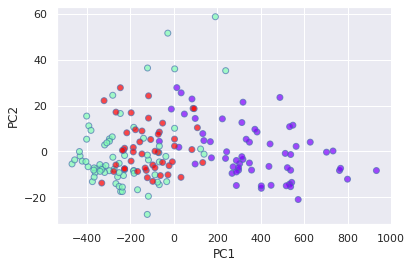

In [22]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

Next, let’s create a model to classify the using the LDA components as features. First, we split the data into training and testing sets.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 10]])

 The Decision Tree classifier correctly classified everything in the test set.